In [ ]:
from astropy.table import Table

import numpy as np
from bliss.reporting import get_snr
from bliss.datasets.galsim_blends import generate_individual_dataset

import torch
import h5py
import matplotlib.pyplot as plt

In [ ]:
catsim_table = Table.read("../../../data/OneDegSq.fits")
mask = catsim_table["i_ab"] < 27.3

new_table = catsim_table[mask]

In [ ]:
# from bliss.datasets.lsst import convert_mag_to_flux
# rows = new_table
# mags = torch.from_numpy(rows["i_ab"].value.astype(float))  # byte order
# gal_flux = convert_mag_to_flux(mags)
# rows["flux"] = gal_flux.numpy().astype(np.float32)

In [ ]:
# rows["flux"].dtype == np.float32

In [ ]:
# a = np.array([1, 2], dtype=float)
# a.dtype == np.float64, float == np.float64, a.dtype == float

In [ ]:
# for sanity, check all dtypes of relevant params

names = (
    "fluxnorm_bulge",
    "fluxnorm_disk",
    "fluxnorm_agn",
    "a_b",
    "a_d",
    "b_b",
    "b_d",
    "pa_bulge",
    "pa_disk",
    "i_ab",
)
for n in names: 
    print(new_table[n].dtype) # all are doubles
    np.allclose(new_table[n].astype(np.float32)[0], new_table[n][0])

>f8
>f8
>f8
>f8
>f8
>f8
>f8
>f8
>f8
>f8


In [ ]:
from bliss.datasets.lsst import get_default_lsst_background, get_default_lsst_psf

psf = get_default_lsst_psf()
background = get_default_lsst_background()

In [ ]:
# ds =generate_individual_dataset(len(new_table), new_table, psf, slen=53, replace=False)
# _ds =generate_individual_dataset(10, new_table, psf, slen=53, replace=False)

In [ ]:
# np.isin(_ds['indices'], new_table['galtileid'])

In [ ]:
# b = torch.from_numpy(ds['indices'].value.astype(int))
# assert np.all(np.isin(b, new_table['galtileid']))
# assert np.all(b.sort()[0].numpy() == np.sort(new_table['galtileid'].value))

In [ ]:
# #save dataset since it took so long to create 

# with h5py.File("../data/data/all_individual_galaxies.hdf5", "w") as f:
#     f.create_dataset('images', data=ds['images'].numpy())
#     f.create_dataset('noiseless', data=ds['noiseless'].numpy())
#     f.create_dataset('galaxy_params', data=ds['galaxy_params'].numpy())
#     f.create_dataset('indices', data=ds['indices'].value.astype(int))
#     f.create_dataset('background', data=ds['background'][0, 0].numpy())

In [ ]:
# load from h5py
ds = {} 
with h5py.File("../data/data/all_individual_galaxies.hdf5", "r") as f:
    print(f.keys())
    ds['images'] = f['images'][:]
    ds['noiseless'] = f['noiseless'][:]
    ds['background'] = f['background'][:]
    ds['galaxy_params'] = f['galaxy_params'][:]
    ds['indices'] = f['indices'][:]

<KeysViewHDF5 ['background', 'galaxy_params', 'images', 'indices', 'noiseless']>


# CATsim galaxies

In [ ]:
images = torch.from_numpy(ds['images'][::10]) # subsample to avoid crashes
noiseless = torch.from_numpy(ds['noiseless'][::10])
images.shape

torch.Size([66648, 1, 53, 53])

In [ ]:
mags = torch.from_numpy(ds['galaxy_params'][:, -2][::10])
mags.shape

torch.Size([66648])

In [ ]:
fluxes = noiseless.sum(dim=(1, 2, 3))
fluxes.shape

torch.Size([66648])

In [ ]:
from bliss.reporting import get_snr


snr = get_snr(noiseless, background)
snr.shape

torch.Size([66648])

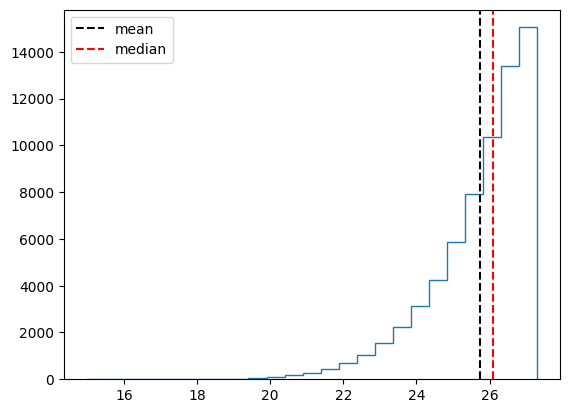

In [ ]:
plt.hist(mags.numpy(), bins=25, histtype='step')
plt.axvline(mags.mean(), linestyle='--', color='k', label='mean')
plt.axvline(mags.median(), linestyle='--', color='r', label='median')
plt.legend()

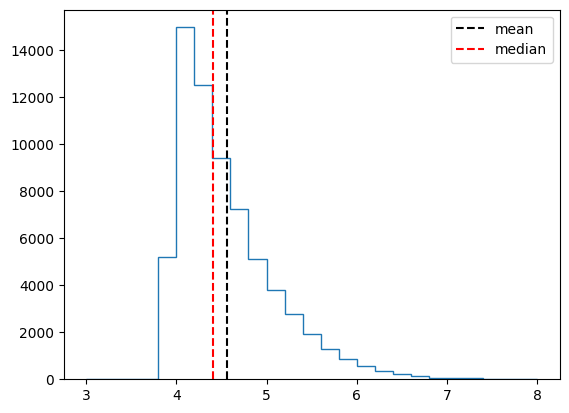

In [ ]:
plt.hist(fluxes.log10().numpy(), bins=25, histtype='step', range=(3, 8))
plt.axvline(fluxes.log10().mean(), linestyle='--', color='k', label='mean')
plt.axvline(fluxes.log10().median(), linestyle='--', color='r', label='median')
plt.legend()

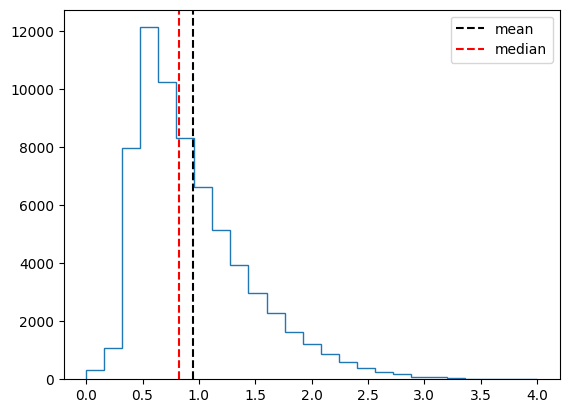

In [ ]:
plt.hist(snr.log10().numpy(), bins=25, histtype='step', range=(0, 4))
plt.axvline(snr.log10().mean(), linestyle='--', color='k', label='mean')
plt.axvline(snr.log10().median(), linestyle='--', color='r', label='median')
plt.legend()

In [ ]:
fluxes_noisy = (images - background).sum(dim=(1, 2, 3))
fluxes_noisy.shape

torch.Size([66648])

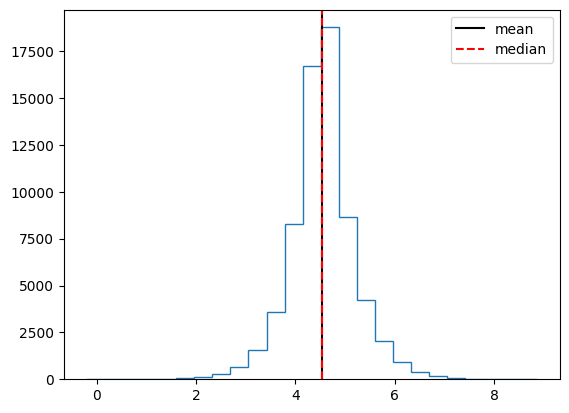

In [ ]:
plt.hist(fluxes_noisy.abs().log10().numpy(), bins=25, histtype='step')
plt.axvline(fluxes_noisy.abs().log10().mean(), linestyle='-', color='k', label='mean')
plt.axvline(fluxes_noisy.abs().log10().median(), linestyle='--', color='r', label='median')
plt.legend()

/home/imendoza/bliss/bliss/plotting.py:256: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  y_bin: np.ndarray = y[keep_x]


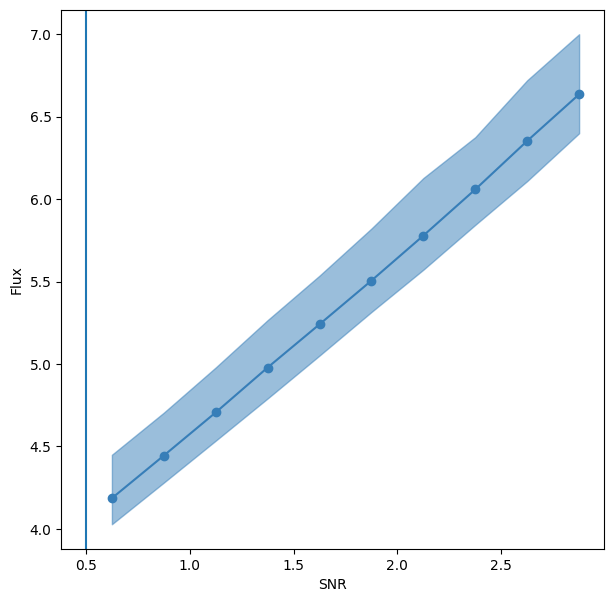

In [ ]:
from bliss.plotting import scatter_shade_plot
fig, ax = plt.subplots(1, 1, figsize=(7,7))
scatter_shade_plot(ax, snr.log10(), fluxes.log10(), xlims=(0.5, 3.0), delta=0.25, qs=(0.025, 0.975))
plt.ylabel("Flux")
plt.xlabel("SNR")
plt.axvline(0.5)

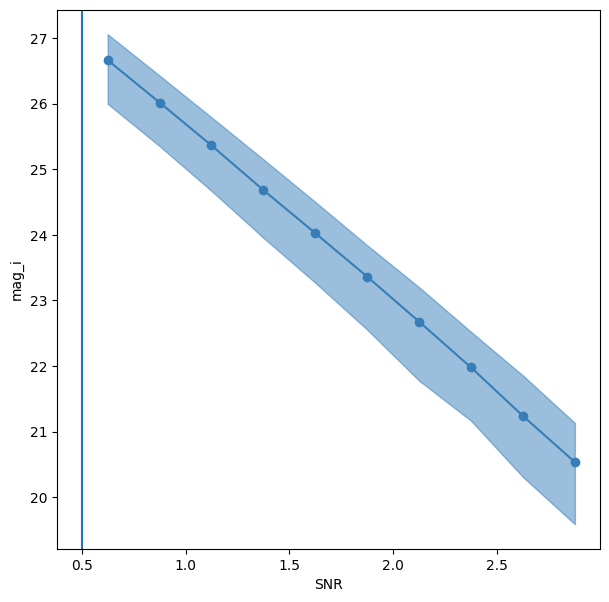

In [ ]:
from bliss.plotting import scatter_shade_plot
fig, ax = plt.subplots(1, 1, figsize=(7,7))
scatter_shade_plot(ax, snr.log10(), mags, xlims=(0.5, 3.0), delta=0.25, qs=(0.025, 0.975))
plt.ylabel("mag_i")
plt.xlabel("SNR")
plt.axvline(0.5)

(3.5, 7.0)

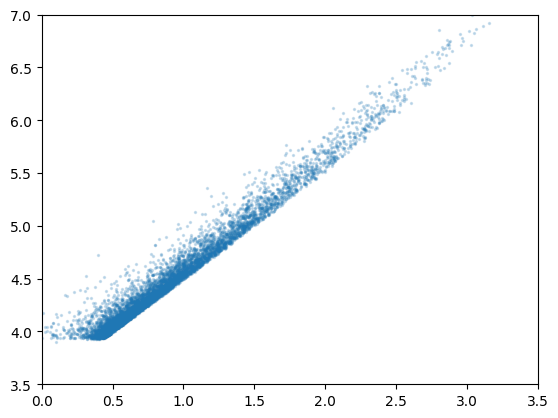

In [ ]:
# first simple scatter plot of flux and snr
plt.scatter(snr.log10()[::10], fluxes.log10()[::10], alpha=0.2, s=2)
plt.xlim(0, 3.5)
plt.ylim(3.5, 7)

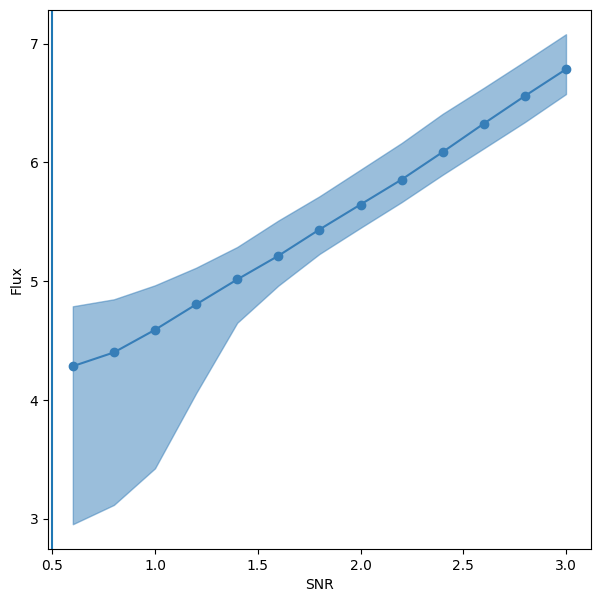

In [ ]:
from bliss.plotting import scatter_shade_plot
fig, ax = plt.subplots(1, 1, figsize=(7,7))
scatter_shade_plot(ax, snr.log10(), fluxes_noisy.abs().log10(), xlims=(0.5, 3.0), delta=0.2, qs=(0.025, 0.975))
plt.ylabel("Flux")
plt.xlabel("SNR")
plt.axvline(0.5)

# Individual galaxy flux scatter

In [ ]:
import galsim

from bliss.datasets.background import add_noise_and_background 
hlr = 0.8
flux = 10**(4.8)
e1 = 0.1
e2 = 0.0

slen = 41

gal = galsim.Gaussian(half_light_radius=hlr, flux=flux)
gal = gal.shear(e1=e1, e2=e2)
gal_conv  = galsim.Convolve([gal, psf])

img = gal_conv.drawImage(nx=slen, ny=slen, scale=0.2)
im = torch.from_numpy(img.array)

im_noisy = add_noise_and_background(im, background)

thres = np.sqrt(flux + background) * 0.1
mask = im > thres
mask.sum(), 41**2, thres

(tensor(255), 1681, 49.67385373091355)

In [ ]:
print(get_snr(im.reshape(1, 1, slen, slen), background))

tensor([10.0734])


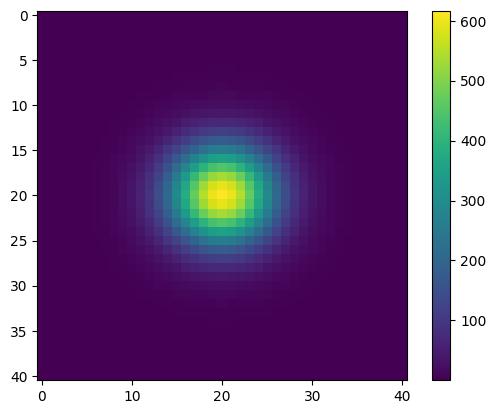

In [ ]:
plt.imshow(im)
plt.colorbar()

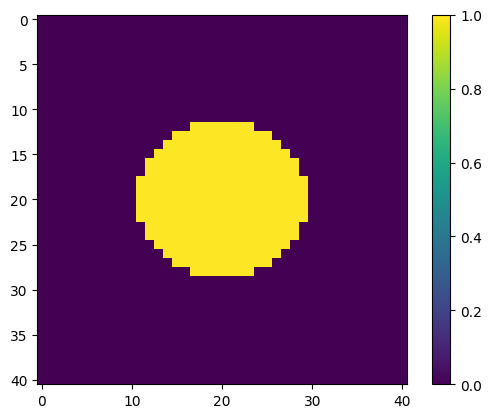

In [ ]:
plt.imshow(mask)
plt.colorbar()

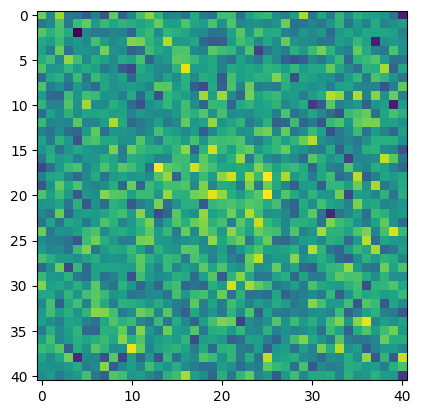

In [ ]:
plt.imshow(im_noisy)

In [ ]:
# flux scatter from noise
fluxes = []
for ii in range(10000): 
    im_noisy = add_noise_and_background(im, background) - background
    fluxes.append(im_noisy[mask].sum())

(array([1.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 6.000e+00, 1.800e+01,
        3.300e+01, 9.300e+01, 2.060e+02, 3.900e+02, 5.760e+02, 8.030e+02,
        1.075e+03, 1.264e+03, 1.371e+03, 1.208e+03, 1.023e+03, 7.260e+02,
        5.380e+02, 3.440e+02, 1.810e+02, 9.000e+01, 3.200e+01, 1.300e+01,
        5.000e+00]),
 array([23670.90625   , 25932.2421875 , 28193.578125  , 30454.9140625 ,
        32716.25195312, 34977.5859375 , 37238.921875  , 39500.26171875,
        41761.59765625, 44022.93359375, 46284.26953125, 48545.60546875,
        50806.94140625, 53068.27734375, 55329.61328125, 57590.94921875,
        59852.28515625, 62113.62109375, 64374.95703125, 66636.296875  ,
        68897.6328125 , 71158.96875   , 73420.3046875 , 75681.640625  ,
        77942.9765625 , 80204.3125    ]),
 <BarContainer object of 25 artists>)

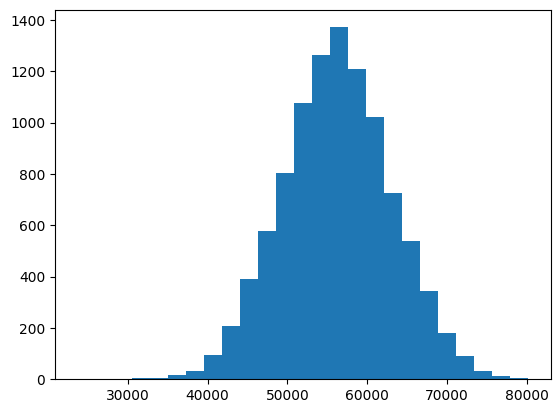

In [ ]:
fluxes = np.array(fluxes)
plt.hist(fluxes, bins=25)

In [ ]:
flux / fluxes.std()

9.236246965595141

In [ ]:
flux

63095.7344480193

# Add SNR and create new catalog

In [ ]:
new_snr_table = new_table.copy()
new_snr_table.sort(keys=['galtileid'])
len(new_snr_table)

666475

In [ ]:
indices = torch.from_numpy(ds['indices'])

In [ ]:
images = torch.from_numpy(ds['images']) # subsample to avoid crashes
noiseless = torch.from_numpy(ds['noiseless'])
images.shape

torch.Size([666475, 1, 53, 53])

In [ ]:
fluxes = noiseless.sum(dim=(1, 2, 3))
fluxes.shape

torch.Size([666475])

In [ ]:
from bliss.reporting import get_snr


snr = get_snr(noiseless, background)
snr.shape

torch.Size([666475])

In [ ]:
sorted_order = torch.argsort(indices)
ids = indices[sorted_order]
snr_sorted = snr[sorted_order]
ids.shape, snr_sorted.shape

(torch.Size([666475]), torch.Size([666475]))

In [ ]:
np.all(ids.numpy() == np.sort(new_snr_table['galtileid']))

True

In [ ]:
new_snr_table['snr'] = snr_sorted.numpy()

In [ ]:
new_snr_table.write("../../../data/catsim_snr.fits", format='fits', overwrite=True)

In [ ]:
loaded_table = Table.read("../../../data/catsim_snr.fits")

In [ ]:
len(new_snr_table), len(loaded_table)

(666475, 666475)

In [ ]:
loaded_table['snr'].dtype, loaded_table['i_ab'].dtype

(dtype('>f4'), dtype('>f8'))

(array([1.10000e+01, 3.90000e+01, 1.57600e+03, 2.19718e+05, 3.03785e+05,
        1.05851e+05, 2.90200e+04, 5.78600e+03, 6.54000e+02, 3.50000e+01]),
 array([-1.94304633e+00, -1.29543865e+00, -6.47831082e-01, -2.23422045e-04,
         6.47384226e-01,  1.29499185e+00,  1.94259953e+00,  2.59020710e+00,
         3.23781466e+00,  3.88542247e+00,  4.53303003e+00]),
 <BarContainer object of 10 artists>)

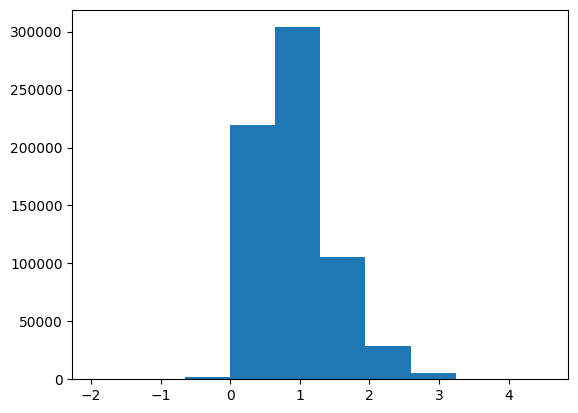

In [ ]:
plt.hist(np.log10(loaded_table['snr']))

In [ ]:
cat =Table.read("../../../data/catsim_snr.fits")
len(cat[cat['snr'] > 10])

245593

In [ ]:
len(cat[(cat["i_ab"] < 27.3) & (cat["snr"] > 10)])

245593